### Inverse dynamcis of `Panda`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mujoco_parser import MuJoCoParserClass
np.set_printoptions(precision=2)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("Ready.")

Ready.


### Util

In [2]:
def plot_id_result(env,sec_list,q_list,torque_list,mode_str=''):
    """
        Plot inverse-dynamics results
    """
    # Plot joint trajectories
    cs = [plt.cm.gist_rainbow(x) for x in np.linspace(0,1,env.n_rev_joint)]
    plt.figure(figsize=(8,3))
    for j_idx in range(env.n_rev_joint):
        plt.plot(sec_list,q_list[:,j_idx],ls='-',color=cs[j_idx],lw=1)
    plt.title('Joint trajectories of [%s]'%(mode_str),fontsize=11)
    plt.xlim(sec_list[0],sec_list[-1])
    plt.xlabel('Time [sec]',fontsize=10)
    plt.ylabel('Joint position [rad]',fontsize=10)
    plt.show()

    # Plot torque trajectories
    cs = [plt.cm.gist_rainbow(x) for x in np.linspace(0,1,env.n_rev_joint)]
    plt.figure(figsize=(8,3))
    for j_idx in range(env.n_rev_joint):
        plt.plot(sec_list,torque_list[:,j_idx],ls='-',color=cs[j_idx],lw=1)
    plt.title('Joint torque of [%s]'%(mode_str),fontsize=11)
    plt.xlim(sec_list[0],sec_list[-1])
    plt.xlabel('Time [sec]',fontsize=10)
    plt.ylabel('Joint torque [Nm]',fontsize=10)
    plt.show()

    # Plot snapshots for Panda with FK
    fig = plt.figure(figsize=(10,4))
    for idx,tick in enumerate(np.linspace(0,max_tick-1,8).astype(np.int32)):
        env.forward(q_pos=q_list[tick,:],q_pos_idxs=env.rev_joint_idxs)
        img = env.plot_scene(render_w=400,render_h=300,
                             cam_distance=2.0,cam_elevation=-45,cam_lookat=[0,0,1.25],RETURN_IMG=True)
        ax = fig.add_subplot(2,4,idx+1)
        ax.imshow(img)
        ax.set_title('[%d/%d] [%.2f]sec'%(tick,max_tick-1,sec_list[tick]),fontsize=8)
print ("Ready.")

Ready.


### Parse `Panda`

In [3]:
env = MuJoCoParserClass(name='Panda',xml_path='../asset/panda/franka_panda.xml')
print ("Done.")

Done.


### Free-fall motion

In [4]:
env.init_viewer(window_width=0.3,window_height=0.3,
                cam_azimuth=80.0,cam_distance=3.0,
                cam_elevation=-30.0,cam_lookat=np.array([0,0,1.5]))
env.reset()
max_tick = 2000
sec_list    = np.zeros(max_tick)
q_list      = np.zeros((max_tick,env.n_rev_joint))
torque_list = np.zeros((max_tick,env.n_rev_joint))
while env.tick < max_tick:
    torque = np.zeros(env.n_rev_joint) # zero torque
    env.step(ctrl=torque,ctrl_idxs=env.rev_joint_idxs)
    env.render()
    # Append
    sec_list[env.tick-1]      = env.get_sim_time()
    q_list[env.tick-1,:]      = env.get_q_pos(q_pos_idxs=env.rev_joint_idxs)
    torque_list[env.tick-1,:] = torque
print ("Done.")

Creating window glfw
Done.


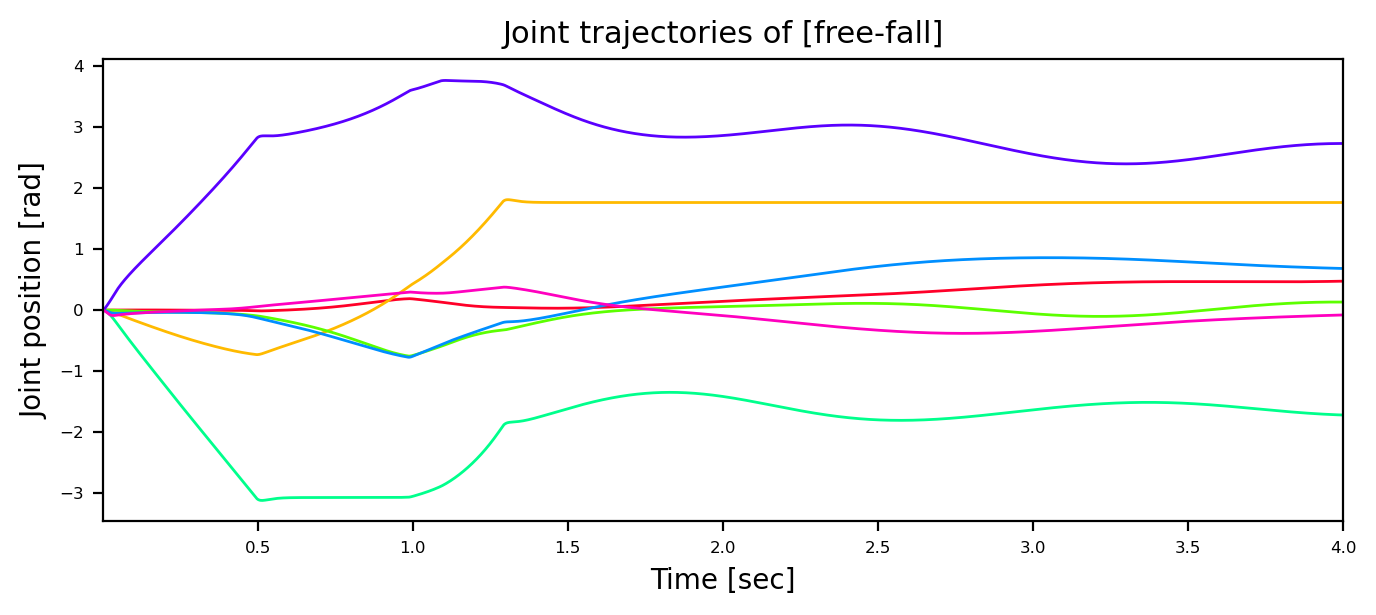

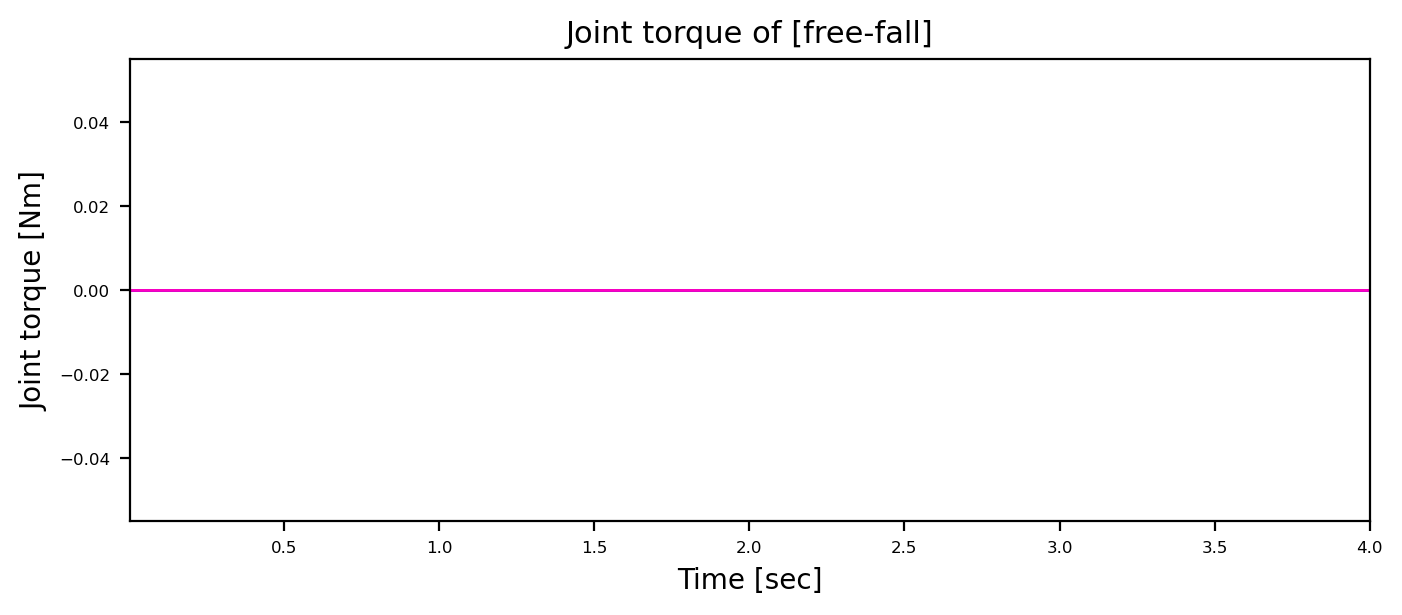

Creating offscreen glfw


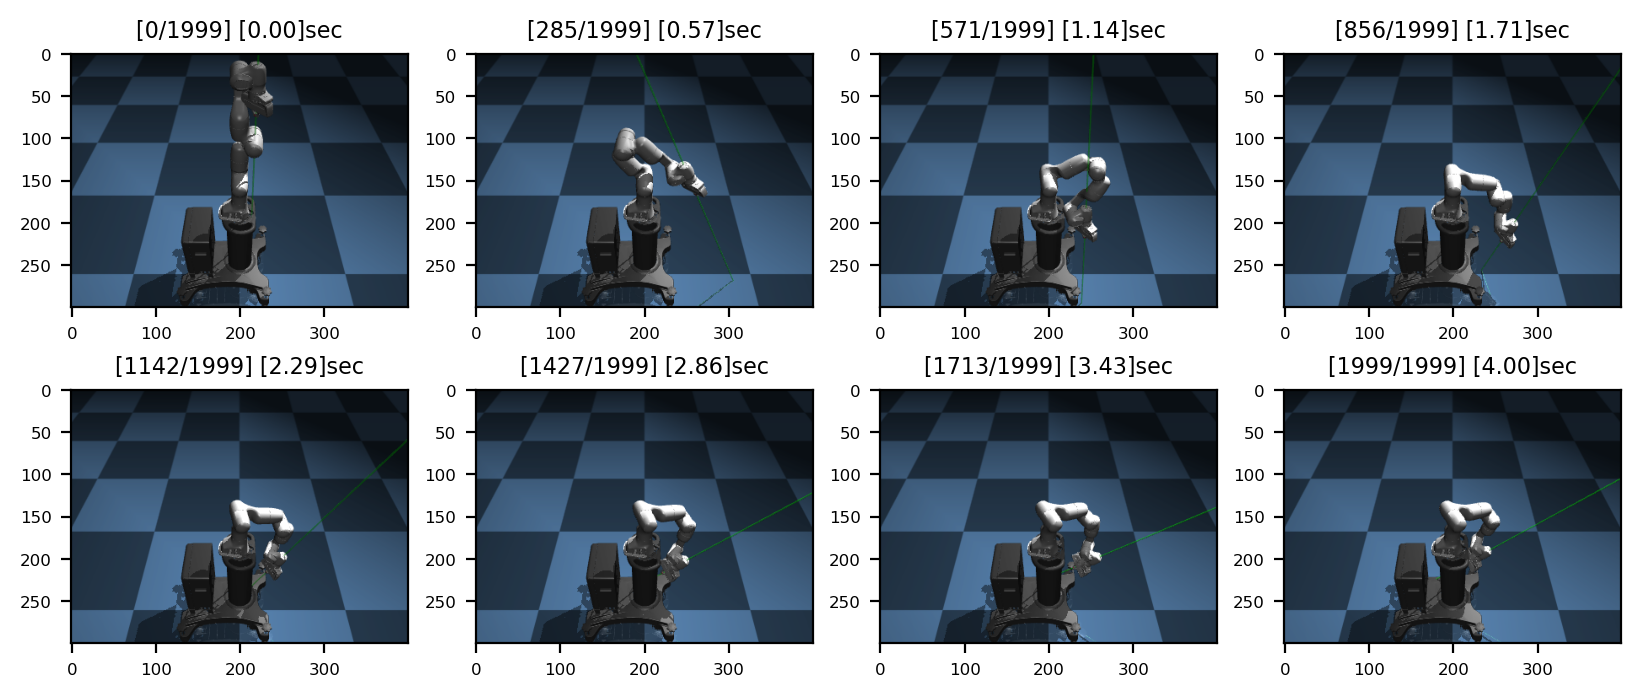

In [5]:
plot_id_result(env,sec_list,q_list,torque_list,mode_str='free-fall')

### Gravity compensation

In [6]:
env.init_viewer(window_width=0.3,window_height=0.3,
                cam_azimuth=80.0,cam_distance=3.0,
                cam_elevation=-30.0,cam_lookat=np.array([0,0,1.5]))
env.reset()
# Set initial manipulation pose
q_des = np.array([0,0,0,-90,0,90,0])*np.pi/180.0
env.forward(q_pos=q_des,q_pos_idxs=env.rev_joint_idxs,INCREASE_TICK=False)
# Buffers
max_tick    = 2000
sec_list    = np.zeros(max_tick)
q_list      = np.zeros((max_tick,env.n_rev_joint))
torque_list = np.zeros((max_tick,env.n_rev_joint))
while env.tick < max_tick:
    # Compute 'torque' from solving inverse dynamics
    qvel = np.zeros(env.n_rev_joint)
    qacc = np.zeros(env.n_rev_joint)
    torque = env.solve_inverse_dynamics(qvel,qacc,joint_idxs = env.rev_joint_idxs)
    # Step
    env.step(ctrl=torque,ctrl_idxs=env.rev_joint_idxs)
    env.render()
    # Append
    sec_list[env.tick-1]      = env.get_sim_time()
    q_list[env.tick-1,:]      = env.get_q_pos(q_pos_idxs=env.rev_joint_idxs)
    torque_list[env.tick-1,:] = torque
print ("Done.")

Done.


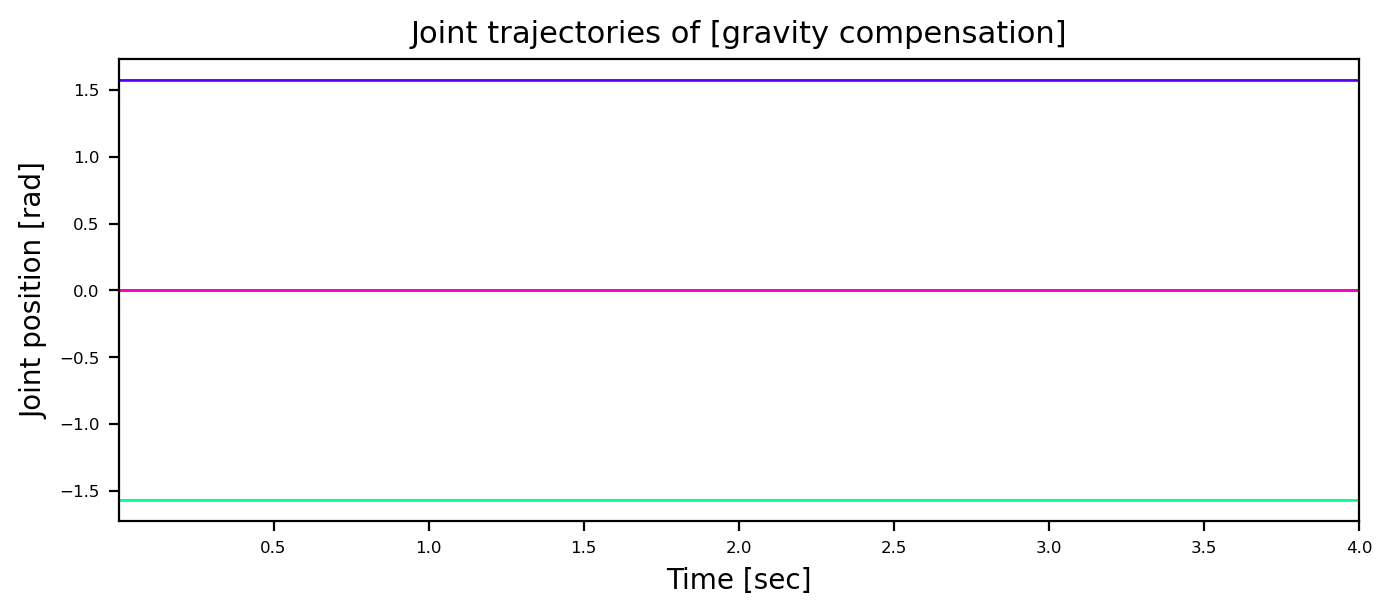

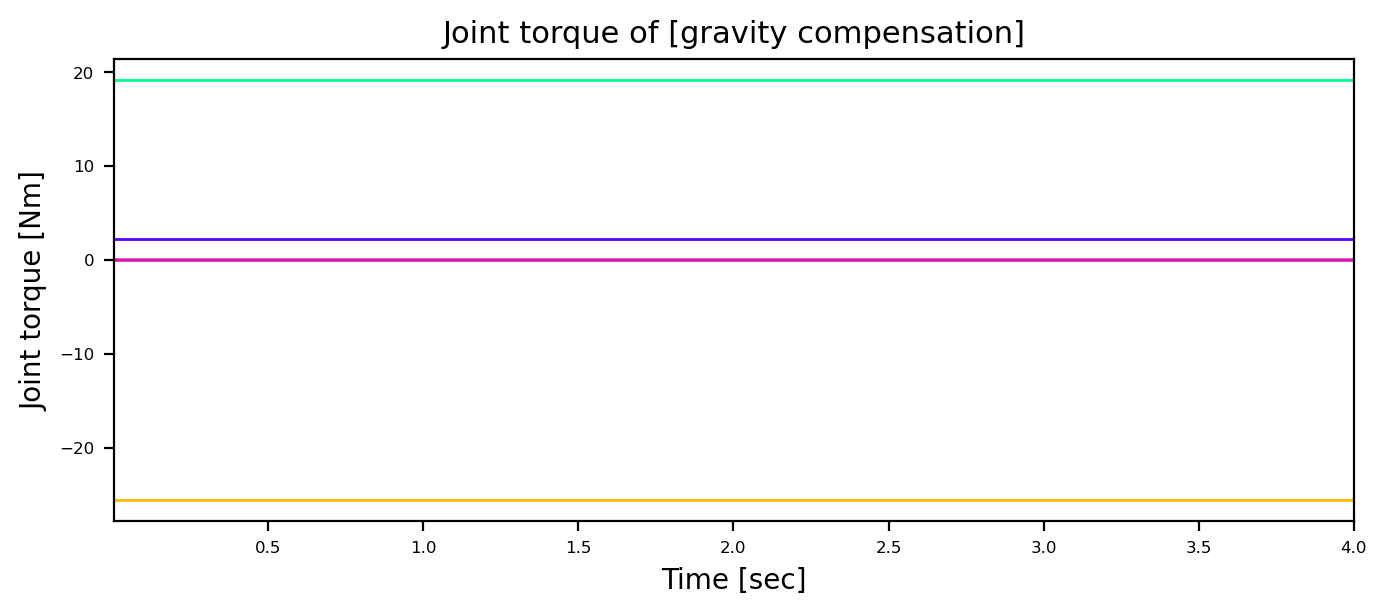

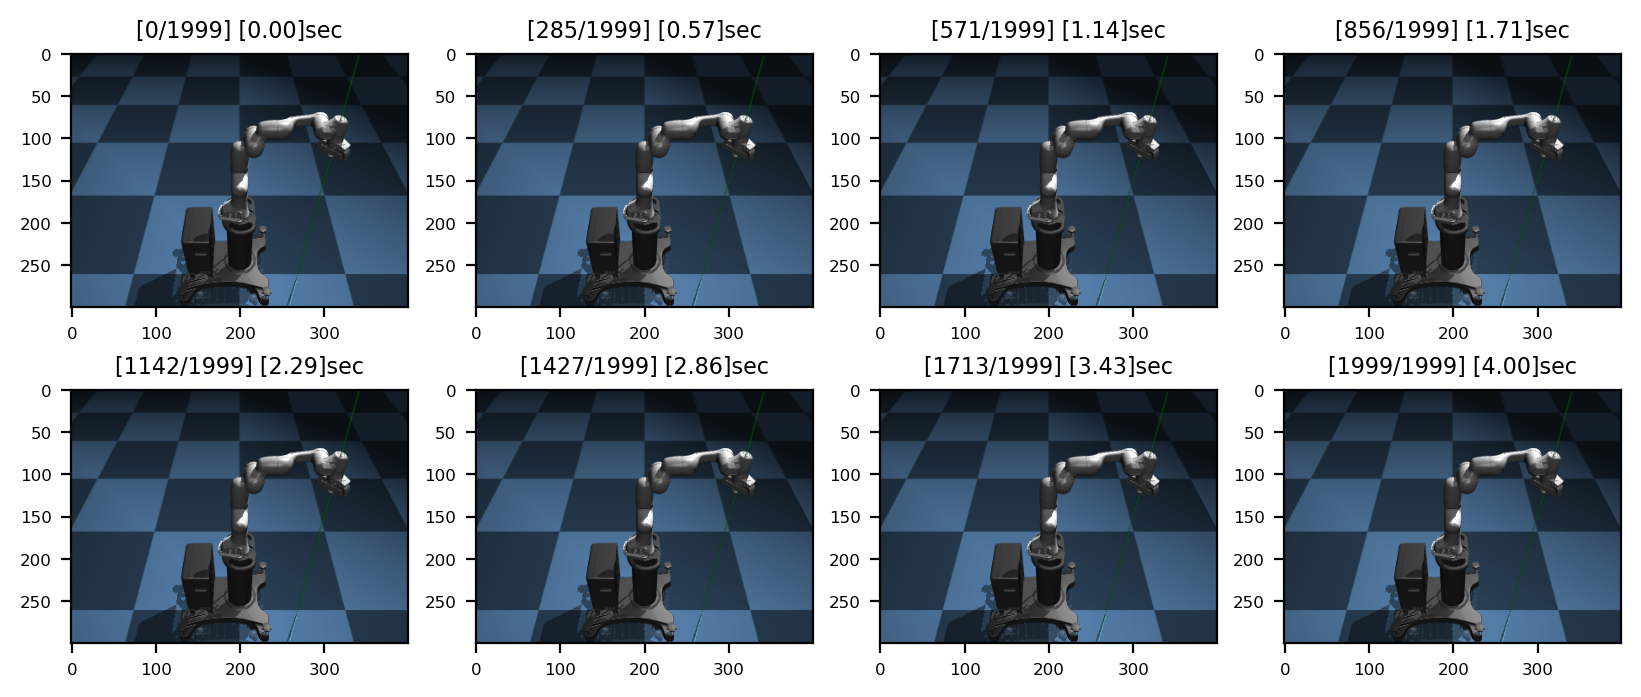

In [7]:
plot_id_result(env,sec_list,q_list,torque_list,mode_str='gravity compensation')

### Spring-like behavior

In [8]:
env.init_viewer(window_width=0.3,window_height=0.3,
                cam_azimuth=80.0,cam_distance=3.0,
                cam_elevation=-30.0,cam_lookat=np.array([0,0,1.5]))
env.reset()
# Set initial manipulation pose
q_des = np.array([0,0,0,-90,0,90,0])*np.pi/180.0
env.forward(q_pos=np.zeros(env.n_rev_joint),q_pos_idxs=env.rev_joint_idxs,INCREASE_TICK=False)
# Buffers
max_tick    = 2000
sec_list    = np.zeros(max_tick)
q_list      = np.zeros((max_tick,env.n_rev_joint))
torque_list = np.zeros((max_tick,env.n_rev_joint))
while env.tick < max_tick:
    # Compute 'torque' from solving inverse dynamics
    qvel = np.zeros(env.n_rev_joint)
    qacc = 50.0*(q_des-env.get_q_pos(q_pos_idxs=env.rev_joint_idxs))
    torque = env.solve_inverse_dynamics(qvel,qacc,joint_idxs = env.rev_joint_idxs)
    # Step
    env.step(ctrl=torque,ctrl_idxs=env.rev_joint_idxs)
    env.render()
    # Append
    sec_list[env.tick-1]      = env.get_sim_time()
    q_list[env.tick-1,:]      = env.get_q_pos(q_pos_idxs=env.rev_joint_idxs)
    torque_list[env.tick-1,:] = torque
print ("Done.")

Done.


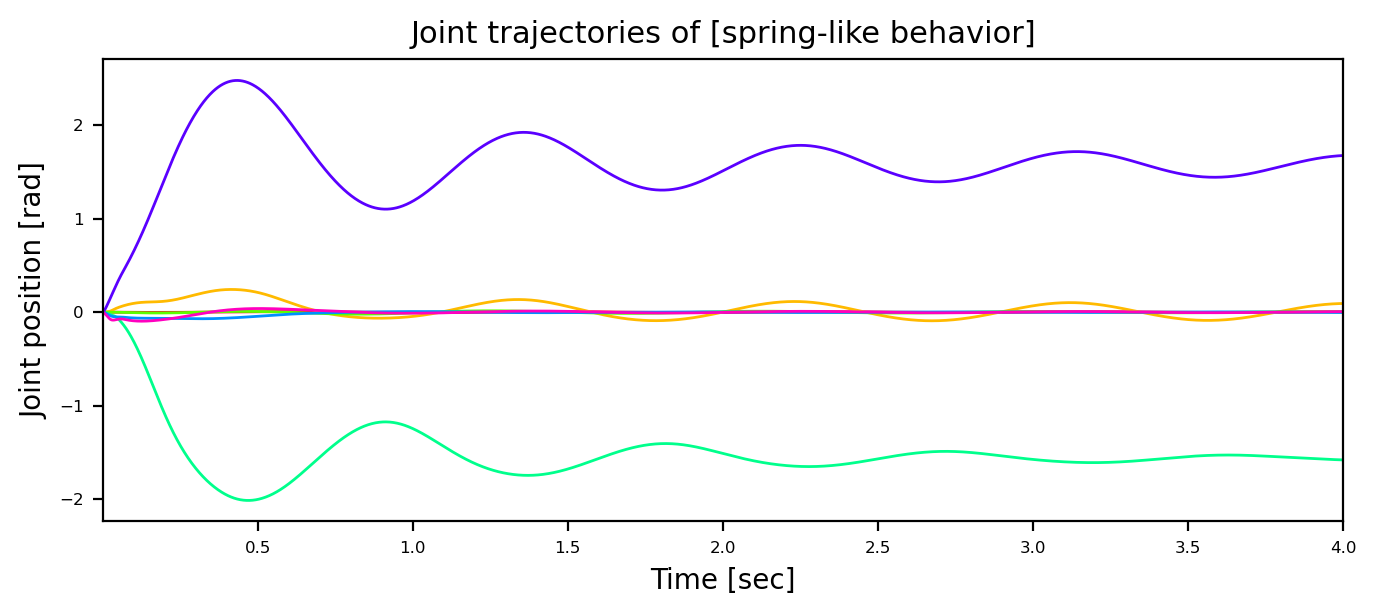

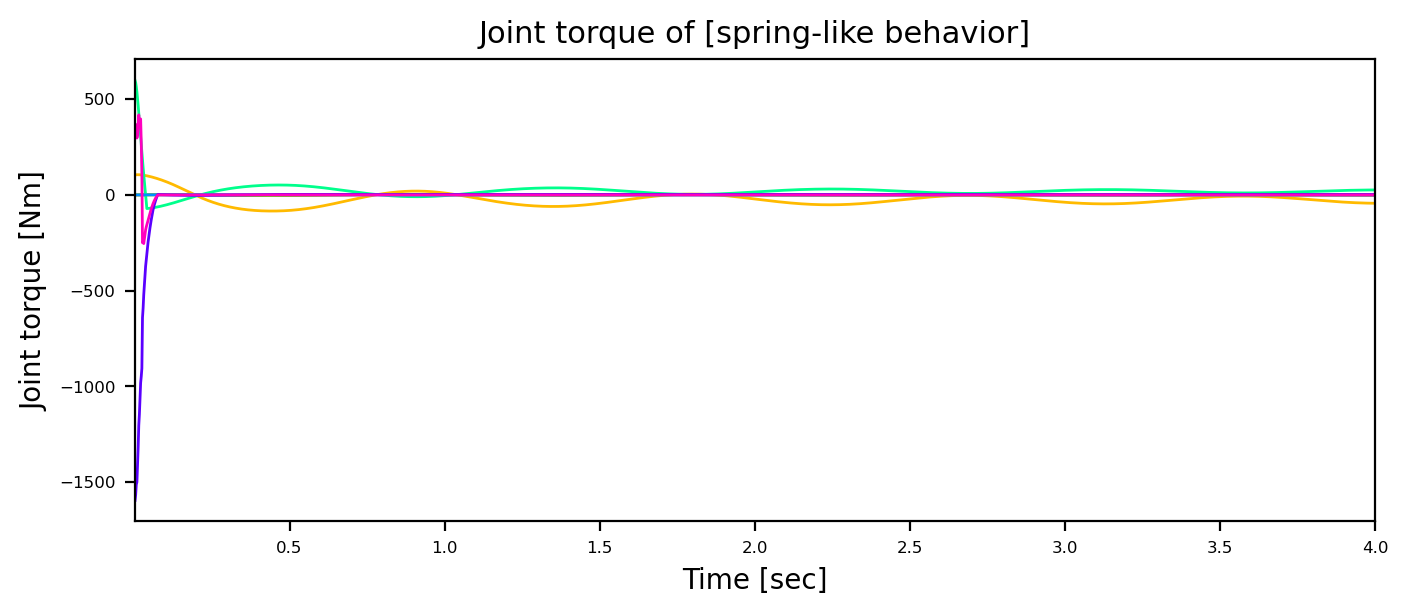

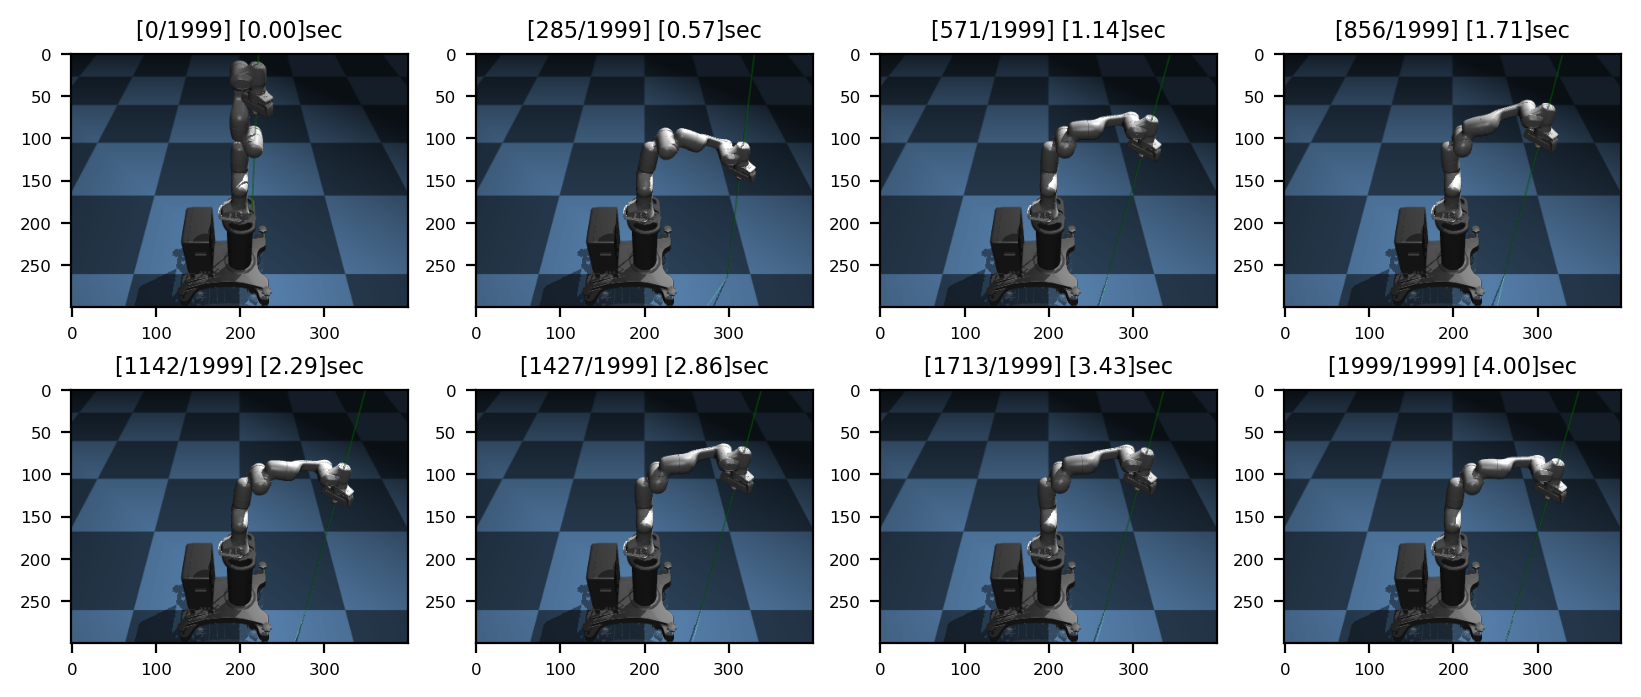

In [9]:
plot_id_result(env,sec_list,q_list,torque_list,mode_str='spring-like behavior')